## Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", parse_dates=True)
# df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', usecols=[1])
df.sort_index(inplace=True)
df.head()

,TS_actual,TS_change,VS_actual,VS_change,PH100,PI100,TI100_SP,TI100_PV,reactor1
day,,,,,,,,,
0,369.5930,0.0000,338.3879,0.000,8.074410,0.0,55,36.000625,0
1,357.2494,12.3436,326.3529,12.035,8.096889,0.0,55,35.664028,100
2,344.9058,12.3436,314.3179,12.035,7.870299,0.0,55,35.768889,120
3,332.5622,12.3436,302.2829,12.035,7.774347,0.0,55,35.843681,100
4,320.2186,12.3436,290.2479,12.035,7.733986,0.0,55,35.853194,100


## Plotting the biogas values
This section takes a look at the trend in the biogas values.

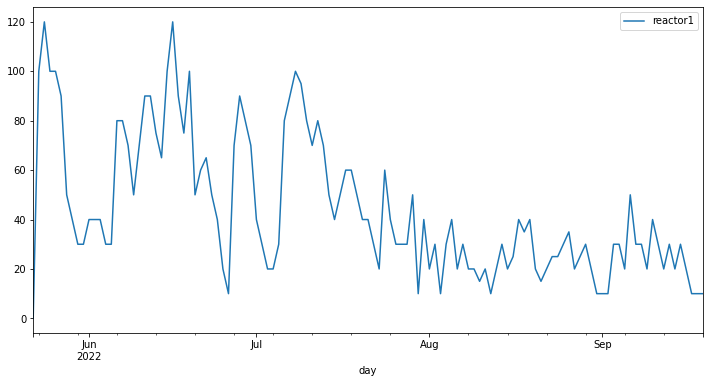

In [ ]:
df.plot(figsize=(12,6))

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

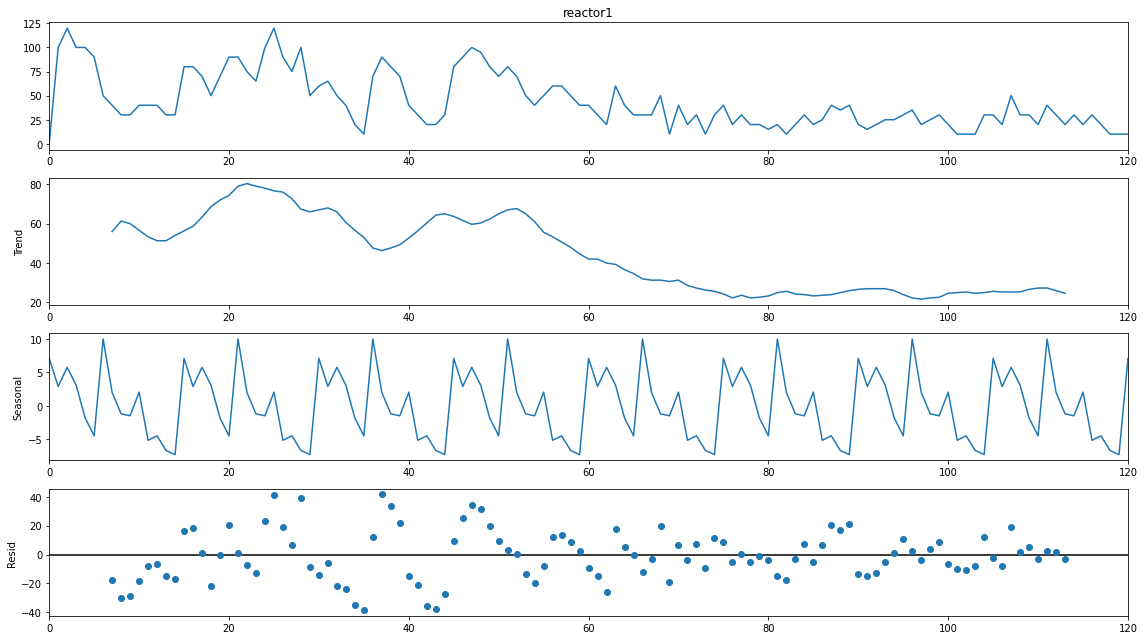

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x=df['reactor1'], period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [ ]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [ ]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), 0]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, 0])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 8
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

112

## Splitting into train and test set
This needs to be done sequentially.

In [ ]:
# Setting a fraction for train data
train_fraction = 0.8
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building ANN models

## a) 1 hidden layer with 64 neurons, RELU activation function

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=sequence_size, activation='relu')) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 67ms/step - loss: 1.0038 - val_loss: 1.3136
Epoch 2/50
3/3 [==============================] - 0s 11ms/step - loss: 0.8830 - val_loss: 1.0813
Epoch 3/50
3/3 [==============================] - 0s 10ms/step - loss: 0.7898 - val_loss: 0.8769
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 0.7086 - val_loss: 0.7081
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 0.6550 - val_loss: 0.5685
Epoch 6/50
3/3 [==============================] - 0s 10ms/step - loss: 0.6086 - val_loss: 0.4593
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 0.5746 - val_loss: 0.3751
Epoch 8/50
3/3 [==============================] - 0s 10ms/step - loss: 0.5479 - val_loss: 0.3114
Epoch 9/50
3/3 [==============================] - 0s 10ms/step - loss: 0.5189 - val_loss: 0.2673
Epoch 10/50
3/3 [==============================] - 0s 11ms/step - loss: 0.4981 - val_loss: 0.2340
Epoch 11/50
3/3 [============

### Plotting the loss

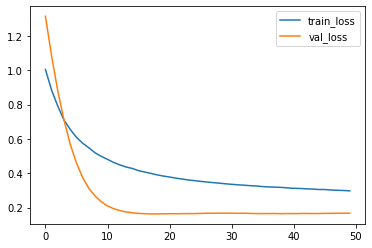

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 3ms/step


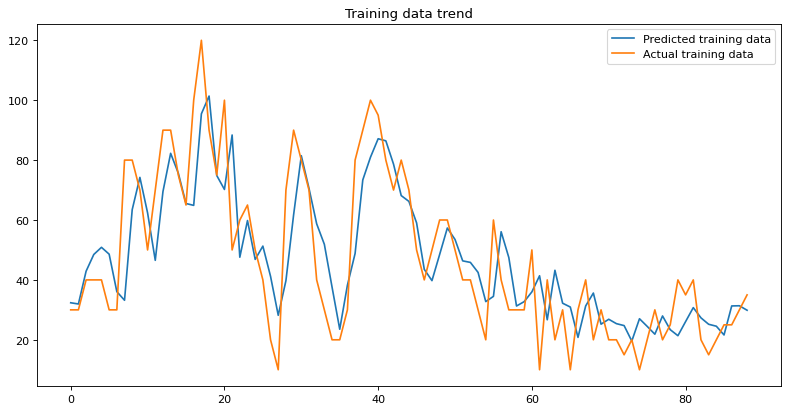

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

1/1 [==============================] - 0s 16ms/step


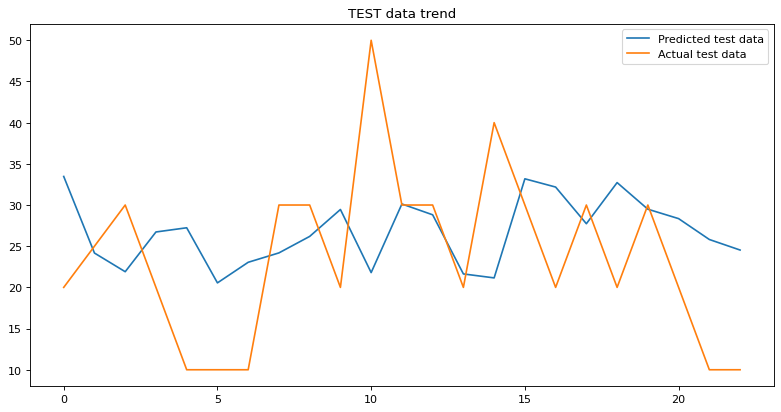

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

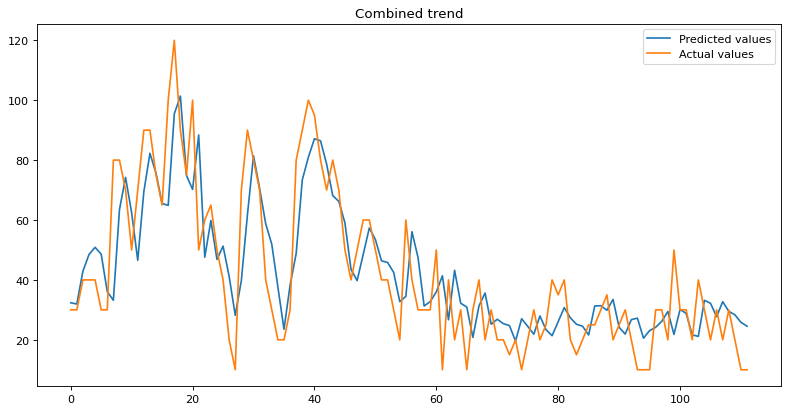

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train data
print(round(r2_score(actual_train, predicted_train), 3))
# Test data
print(round(r2_score(actual_test, predicted_test),3))
# Combined data
print(round(r2_score(actual_combined, predicted_combined),3))

0.665
-0.307
0.679


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train data
print(round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3))

# Test data
print(round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3))

# Combined data
print(round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


15.243
11.46
14.547


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. The trend in the values seems to changing later than the actual values. (the graph of actual values is preceeding the predicted values)
2. For the training data, the model is *under-predicting* the change in values.
3. For the testing data, there is a general trend where the predicted values are more than the actual values. The lag is still present.
4. r2 scores: 0.548, -1.154, 0.579
5. RMSE: 18.548, 13.892, 17.25

**2. Sequence size of 15, train size of 0.7**  
1. On the training data, the model is predicting values better.
2. On the testing data, there is still some lag, even though general trend is still being followed.
3. r2 scores: 0.742, -0.507, 0.744
4. RMSE: 13.996, 11.782, 13.36

## b) 2 hidden layer with 32 neurons each, RELU activation function

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=sequence_size, activation='relu')) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
3/3 [==============================] - 0s 50ms/step - loss: 1.2215 - val_loss: 0.2495
Epoch 2/50
3/3 [==============================] - 0s 11ms/step - loss: 1.0976 - val_loss: 0.2376
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9775 - val_loss: 0.2243
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 0.8810 - val_loss: 0.2116
Epoch 5/50
3/3 [==============================] - 0s 11ms/step - loss: 0.8019 - val_loss: 0.2006
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.7362 - val_loss: 0.1902
Epoch 7/50
3/3 [==============================] - 0s 11ms/step - loss: 0.6968 - val_loss: 0.1833
Epoch 8/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6556 - val_loss: 0.1768
Epoch 9/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6319 - val_loss: 0.1737
Epoch 10/50
3/3 [==============================] - 0s 12ms/step - loss: 0.6000 - val_loss: 0.1695
Epoch 11/50
3/3 [============

### Plotting the loss

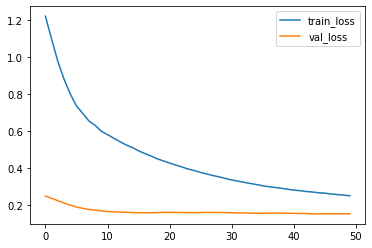

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 3ms/step


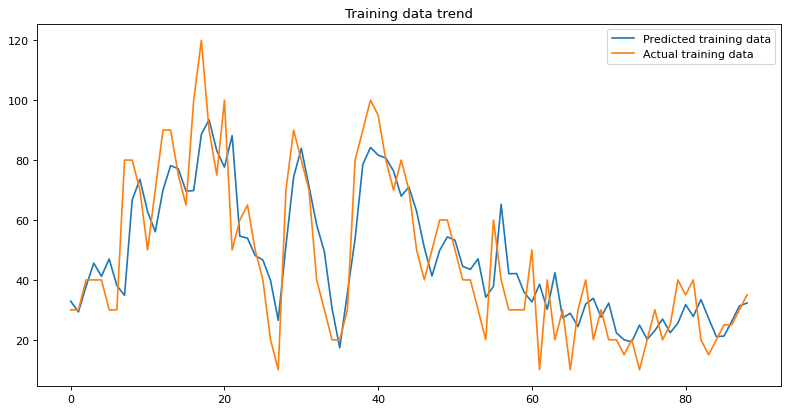

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

1/1 [==============================] - 0s 15ms/step


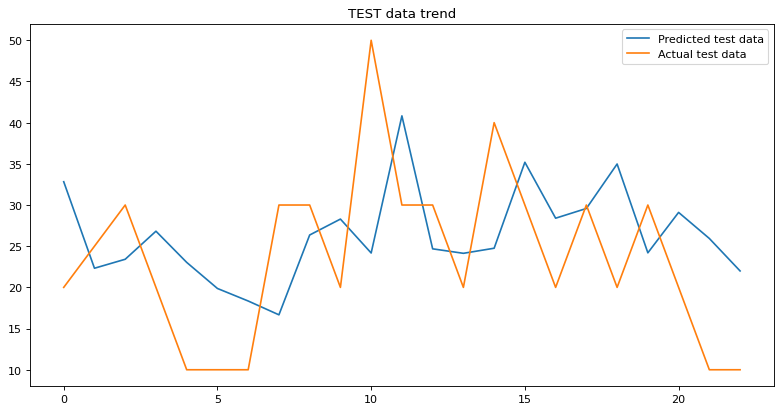

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

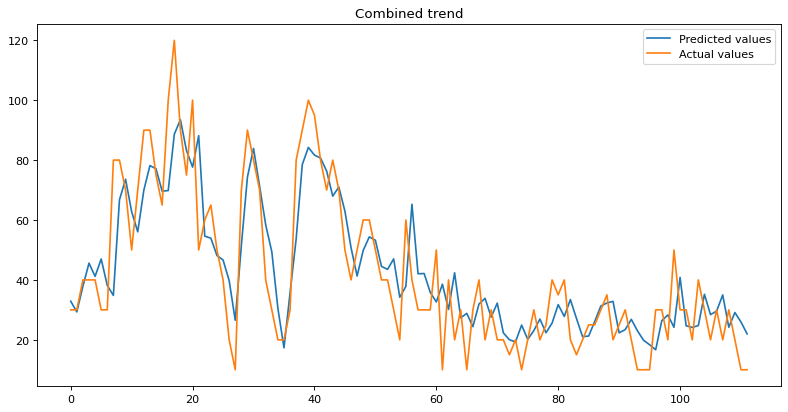

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train data
print(round(r2_score(actual_train, predicted_train), 3))
# Test data
print(round(r2_score(actual_test, predicted_test),3))
# Combined data
print(round(r2_score(actual_combined, predicted_combined),3))

0.719
-0.193
0.728


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train data
print(round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3))

# Test data
print(round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3))

# Combined data
print(round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


13.957
10.948
13.394


### Analysis
**1. Sequence size of 10, train size of 0.8**
1. The test values are very close to the mean.
2. r2 scores: 0.797, -0.006, 0.798
3. RMSE: 11.946, 10.246, 11.626

**2. Sequence size of 5, train size of 0.8**  
1. The values deteriorated.
2. r2 scores: 0.662, -0.343, 0.677
3. RMSE: 15.284, 11.615, 14.624

## c) 3 hidden layer with 16 neurons each, RELU activation function

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=sequence_size, activation='relu')) 
model.add(Dense(16, activation='relu')) 
model.add(Dense(16, activation='relu')) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary()) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 54ms/step - loss: 0.7869 - val_loss: 0.4325
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.7587 - val_loss: 0.4124
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.7324 - val_loss: 0.3866
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 0.7075 - val_loss: 0.3604
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.6875 - val_loss: 0.3359
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.6656 - val_loss: 0.3105
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.6454 - val_loss: 0.2887
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6257 - val_loss: 0.2653
Epoch 9/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6082 - val_loss: 0.2485
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.5894 - val_loss: 0.2299
Epoch 11/100
3/3 [==

### Plotting the loss

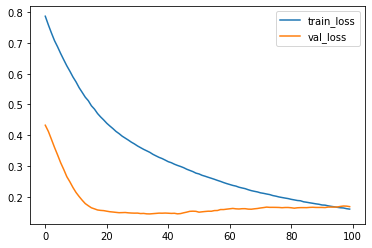

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 3ms/step


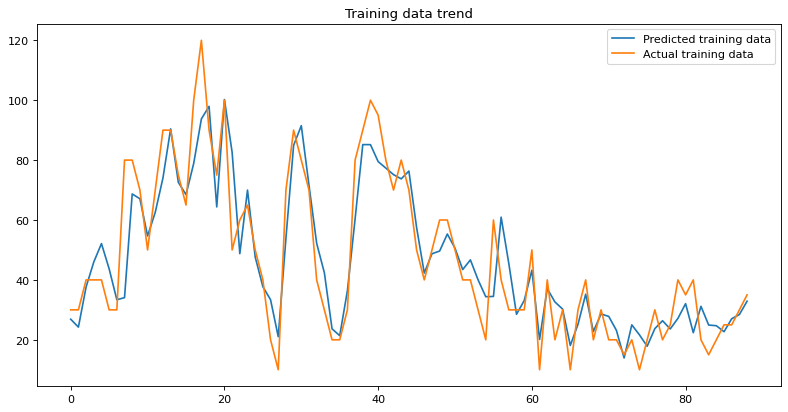

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

predicted_train_inv = scaler.inverse_transform(predicted_train)
actual_train_inv = scaler.inverse_transform(actual_train)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

1/1 [==============================] - 0s 16ms/step


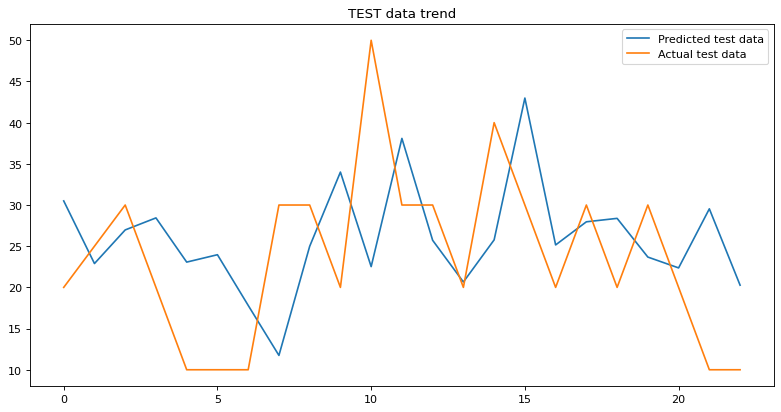

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

predicted_test_inv = scaler.inverse_transform(predicted_test)
actual_test_inv = scaler.inverse_transform(actual_test)

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

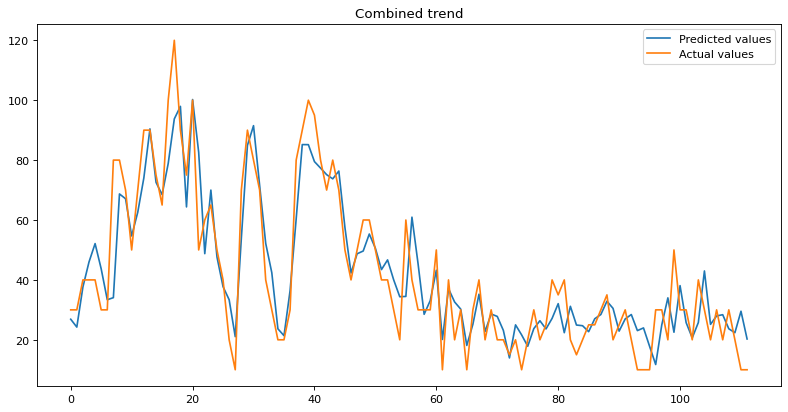

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)
actual_combined_inv = scaler.inverse_transform(actual_combined)
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train data
print(round(r2_score(actual_train, predicted_train), 3))
# Test data
print(round(r2_score(actual_test, predicted_test),3))
# Combined data
print(round(r2_score(actual_combined, predicted_combined),3))


0.821
-0.307
0.81


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train data
print(round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3))

# Test data
print(round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3))

# Combined data
print(round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


11.13
11.459
11.199


### Analysis
**1. Sequence size of 5, train size of 0.8**
1. The test values followed trend faintly, close to the mean
2. r2 scores: 0.711, -0.489, 0.714
3. RMSE: 14.131, 12.231, 13.772

**2. Sequence size of 8, train size of 0.8**  
1. The values follow the trend more closely, still close to the mean
2. r2 scores: 0.759, -0.267, 0.759
3. RMSE: 12.918, 11.281, 12.599